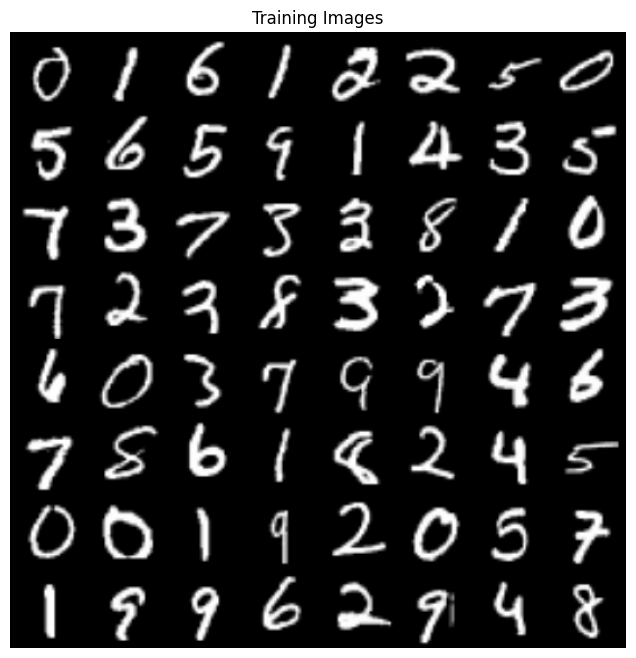

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch.utils.data
import torchvision.utils as vutils
from torchvision.datasets import MNIST
dataset = MNIST(root='.', download=True, transform=transforms.Compose([
                     transforms.Resize(64),
                     transforms.ToTensor(),
                     transforms.Normalize((0.5,), (0.5,))
                     ]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=128,
                                         shuffle=True, num_workers=2)
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
# Plot training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

# Define GAN

In [24]:
from torch.nn.modules.conv import Conv2d
from torch.nn.modules.activation import ReLU
from torch.nn.modules.batchnorm import BatchNorm2d
import torch
import torch.nn as nn
import torch.nn.functional as F

def weights_init(m):
  classname = m.__class__.__name__
  if classname.find('Conv') != -1:
      m.weight.data.normal_(0.0, 0.02)
  elif classname.find('BatchNorm') != -1:
      m.weight.data.normal_(1.0, 0.02)
      m.bias.data.fill_(0)

class Generator(nn.Module):
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
        # input layer
        nn.ConvTranspose2d(100, 64 * 8, 4, 1, 0, bias=False),
        nn.BatchNorm2d(64 * 8),
        nn.ReLU(True),
        # 1st hidden layer
        nn.ConvTranspose2d(64 * 8, 64 * 4, 4, 2, 1, bias=False),
        nn.BatchNorm2d(64 * 4),
        nn.ReLU(True),
        # 2nd hidden layer
        nn.ConvTranspose2d(64 * 4, 64 * 2, 4, 2, 1, bias=False),
        nn.BatchNorm2d(64 * 2),
        nn.ReLU(True),
        # 3rd hidden layer
        nn.ConvTranspose2d(64 * 2, 64, 4, 2, 1, bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU(True),
        # output layer
        nn.ConvTranspose2d(64, 1, 4, 2, 1, bias=False),
        nn.Tanh()
    )
  def forward(self, x):
    return self.layers(x)

class Discriminator(nn.Module):
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
        # 1st layer
        nn.Conv2d(1, 64, 4, 2, 1, bias=False),
        nn.LeakyReLU(0.2, inplace=True),
        # 2nd layer
        nn.Conv2d(64, 64 * 2, 4, 2, 1, bias=False),
        nn.BatchNorm2d(64 * 2),
        nn.LeakyReLU(0.2, inplace=True),
        # 3rd layer
        nn.Conv2d(64 * 2, 64 * 4, 4, 2, 1, bias=False),
        nn.BatchNorm2d(64 * 4),
        nn.LeakyReLU(0.2, inplace=True),
        # 4th layer
        nn.Conv2d(64 * 4, 64 * 8, 4, 2, 1, bias=False),
        nn.BatchNorm2d(64 * 8),
        nn.LeakyReLU(0.2, inplace=True),
        # output layer
        nn.Conv2d(64 * 8, 1, 4, 1, 0, bias=False),
        nn.Sigmoid()
    )
  def forward(self, x):
    return self.layers(x)

gen = Generator()
disc = Discriminator()

if torch.cuda.is_available:
  gen = gen.cuda()
  disc = disc.cuda()

gen.apply(weights_init)
disc.apply(weights_init)
print(gen)
print(disc)

Generator(
  (layers): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )


In [25]:
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

def generate_samples(model, num_samples):
  noise = torch.randn(num_samples, 100, 1, 1, device=device)
  images = model(noise)
  return images

# Generate initial images

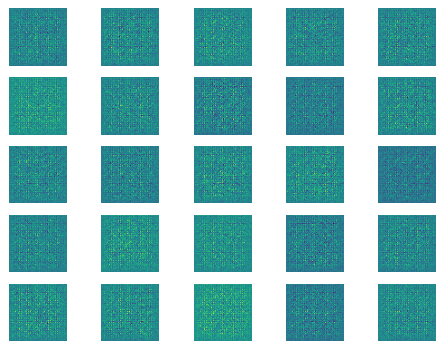

In [26]:
gen.eval()
samples = generate_samples(gen, 25).detach().cpu().numpy()
plt.figure(dpi=90)
for i in range(25):
  plt.subplot(5, 5, i+1)
  plt.imshow(np.transpose(samples[i], (1,2,0)))
  plt.axis('off')
plt.show()

# Train GAN

In [19]:
def train_gan(gen, disc, images, num_epochs, batch_size):
    from tqdm.autonotebook import tqdm
    from torch.utils.data import DataLoader

    losses_gen = []
    losses_disc = []
    loss_func = nn.BCELoss()
    loss_func_gen = nn.BCELoss()
    gen.train()
    disc.train()

    optimizer_gen = torch.optim.Adam(gen.parameters(), lr = 2e-4, betas=(0.5, 0.999))
    optimizer_disc = torch.optim.Adam(disc.parameters(), lr = 2e-4, betas=(0.5, 0.999))

    pbar = tqdm(range(num_epochs))
    for e in pbar:
        for i, data_real in enumerate(dataloader):
            if torch.cuda.is_available:
                data_real = data_real[0].cuda()

            # zero gradient
            optimizer_disc.zero_grad()

            # Generate images and labels
            inputs_disc_real = data_real
            b_size = data_real.size(0)
            inputs_disc_fake = generate_samples(gen, b_size)
            labels_disc_fake = torch.full((b_size,), 0, dtype=torch.float, device=device)
            labels_disc_real = torch.full((b_size,), 1, dtype=torch.float, device=device)

            if torch.cuda.is_available:
                inputs_disc_real = inputs_disc_real.cuda()
                inputs_disc_fake = inputs_disc_fake.cuda()
                labels_disc_fake = labels_disc_fake.cuda()
                labels_disc_real = labels_disc_real.cuda()

            # Generating real sample output and loss
            output_disc_real = disc(inputs_disc_real).view(-1)
            loss_real = loss_func(output_disc_real, labels_disc_real)
            loss_real.backward()

            # Generating fake sample output and loss
            output_disc_fake = disc(inputs_disc_fake).view(-1)
            loss_fake = loss_func(output_disc_fake, labels_disc_fake)
            loss_fake.backward()


            # loss
            loss_disc = (loss_real + loss_fake)
            losses_disc.append(loss_disc.item())


            # Update discriminator
            optimizer_disc.step()

            # zero gradient
            optimizer_gen.zero_grad()
            inputs_gen = generate_samples(gen, b_size)
            labels_gen = torch.full((b_size,), 1, dtype=torch.float, device=device)

            if torch.cuda.is_available:
                inputs_gen = inputs_gen.cuda()
                labels_gen = labels_gen.cuda()

            output_gen = disc(inputs_gen).view(-1)
            loss_gen = loss_func_gen(output_gen, labels_gen)
            loss_gen.backward()
            losses_gen.append(loss_gen.item())

            # Update generator
            optimizer_gen.step()
    ####################################################################################

            pbar.set_postfix(loss_gen=losses_gen[-1], loss_disc=losses_disc[-1])
    return losses_gen, losses_disc

In [27]:
num_epochs = 7
batch_size = 128
losses_gen, losses_disc = train_gan(gen, disc, dataset, num_epochs=num_epochs, batch_size=batch_size)

  0%|          | 0/7 [00:00<?, ?it/s]

# Plot Losses

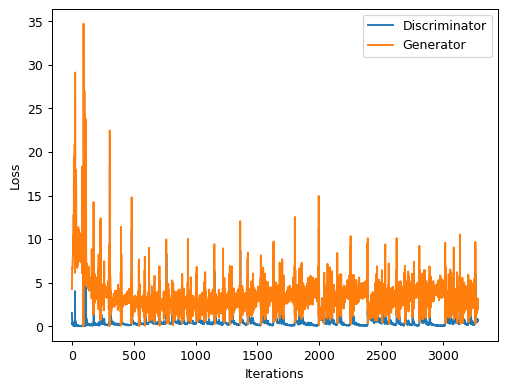

In [28]:
plt.figure(dpi=90)
plt.plot(losses_disc, label='Discriminator')
plt.plot(losses_gen, label='Generator')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Generate Samples

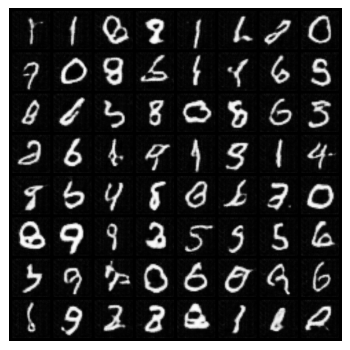

In [31]:
gen.eval()
samples = generate_samples(gen, 64).detach().cpu()
grid = vutils.make_grid(samples, padding=5, normalize=True)
plt.figure(dpi=90)
plt.axis("off")
plt.imshow(np.transpose(grid,(1,2,0)))
plt.show()

These are the generated images after 7 epochs (3500 iterations)